# Fine-tuning Classifier LLM


In [1]:
# setup - load packages
import pandas as pd
from datasets import Dataset
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns

seed = 13

In [ ]:
classifier_data = pd.read_csv("../data/classifier_data_A.csv")
# converting to huggingface dataset format
data = Dataset.from_pandas(classifier_data)
# splitting into train, test and validation sets
# party data
raw_dataset = data.shuffle(seed=seed)

# 70% train, 15% test, 15% validation data
split = raw_dataset.train_test_split(test_size=0.3, seed=seed)
train_data = split["train"]
text_and_val_data = split["test"]
split = text_and_val_data.train_test_split(test_size=0.5, seed=seed)
test_data = split["train"]
val_data = split["test"]

print(f"Training samples party: {len(train_data)}")
print(f"test samples party: {len(test_data)}")
print(f"Validation samples party: {len(val_data)}")



# data balancing??

In [3]:
# Load Model
model_name = "bert-base-german-cased"
num_labels = 6
max_length = 512
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels= num_labels) # classification head with one linear layer and num_label outputs is added on top of model here.

print(f"Model parameters: {model.num_parameters():,}")

# quantized?!

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/485k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 109,085,958


In [10]:
# define prediction function
# Define possible label names
label_names = ['CDU/CSU', 'SPD', 'GRÜNE', 'FDP', 'AfD', 'LINKE']


def predicting_probs(model, speech, max_length=512):
    model.eval()

    # Tokenize full speech (no truncation)
    tokens = tokenizer(speech, return_tensors="pt", truncation=False)["input_ids"][0]

    # Split into chunks
    chunks = [tokens[i:i + max_length] for i in range(0, len(tokens), max_length)]

    # Pad chunks to max_length
    padded_chunks = []
    for chunk in chunks:
        if len(chunk) < max_length:
            # pad with pad_token_id
            padding = torch.full((max_length - len(chunk),), tokenizer.pad_token_id, dtype=torch.long)
            chunk = torch.cat([chunk, padding])
        padded_chunks.append(chunk)

    # Stack into batch tensor
    input_ids_batch = torch.stack(padded_chunks)
    attention_mask_batch = (input_ids_batch != tokenizer.pad_token_id).long()

    # Predict
    with torch.no_grad():
        outputs = model(input_ids=input_ids_batch, attention_mask=attention_mask_batch)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=1)

    # Average over chunks
    avg_probs = torch.mean(probabilities, dim=0)

    return avg_probs



def predicting_probs_to_preds(model, speech):
    # get probabilites
    probabilities = predicting_probs(model, speech)
    # convert to predictions
    predictions_nr = torch.argmax(probabilities).item()
    predictions = label_names[predictions_nr]
    return predictions, probabilities



In [11]:
# collect evaluation data
def evaluate_model(model, data):
    prediction_list = []
    probability_list = []
    true_label_list = []

    for i, row in enumerate(data):
        speech = row["speech_text"]
        pred, probs = predicting_probs_to_preds(model, speech)
        true_label = row["label"]
        prediction_list.append(pred)
        probability_list.append(probs)
        true_label_list.append(true_label)

        if (i+1) % 100 == 0:
            print(f"Processed samples {i+1} of {len(data)} samples.")

    return prediction_list, probability_list, true_label_list


# define function to display eval metrics
def get_metrics(true_labels, preds):
    metrics_summary = {}

    acc = accuracy_score(true_labels, preds)
    bal_acc = balanced_accuracy_score(true_labels, preds)

    precision = precision_score(true_labels, preds, average='macro', zero_division=0)
    recall = recall_score(true_labels, preds, average='macro', zero_division=0)
    f1 = f1_score(true_labels, preds, average='macro', zero_division=0)

    label_order = sorted(set(true_labels).union(set(preds)))
    report = classification_report(true_labels, preds, labels=label_order, zero_division=0)
    metrics_summary[model_name] = {
        'acc': acc,
        'bal_acc': bal_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    # print metrics
    print(f"Model: {model_name}")
    print(f"  Accuracy: {acc}")
    print(f"  Balanced Accuracy: {bal_acc}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1-score: {f1}")
    print(f"  Classification Report:\n{report}")


    # Confusion Matrix
    label_order = sorted(set(true_labels).union(set(preds)))
    cm = confusion_matrix(true_labels, preds, labels=label_order)
    cm_df = pd.DataFrame(cm, index=label_order, columns=label_order)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


    return metrics_summary







/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Processed samples 100 of 3999 samples.
Processed samples 200 of 3999 samples.
Processed samples 300 of 3999 samples.
Processed samples 400 of 3999 samples.
Processed samples 500 of 3999 samples.
Processed samples 600 of 3999 samples.
Processed samples 700 of 3999 samples.
Processed samples 800 of 3999 samples.
Processed samples 900 of 3999 samples.
Processed samples 1000 of 3999 samples.
Processed samples 1100 of 3999 samples.
Processed samples 1200 of 3999 samples.
Processed samples 1300 of 3999 samples.
Processed samples 1400 of 3999 samples.
Processed samples 1500 of 3999 samples.
Processed samples 1600 of 3999 samples.
Processed samples 1700 of 3999 samples.
Processed samples 1800 of 3999 samples.
Processed samples 1900 of 3999 samples.
Processed samples 2000 of 3999 samples.
Processed samples 2100 of 3999 samples.
Processed samples 2200 of 3999 samples.
Processed samples 2300 of 3999 samples.
Processed samples 2400 of 3999 samples.
Processed samples 2500 of 3999 samples.
Processed

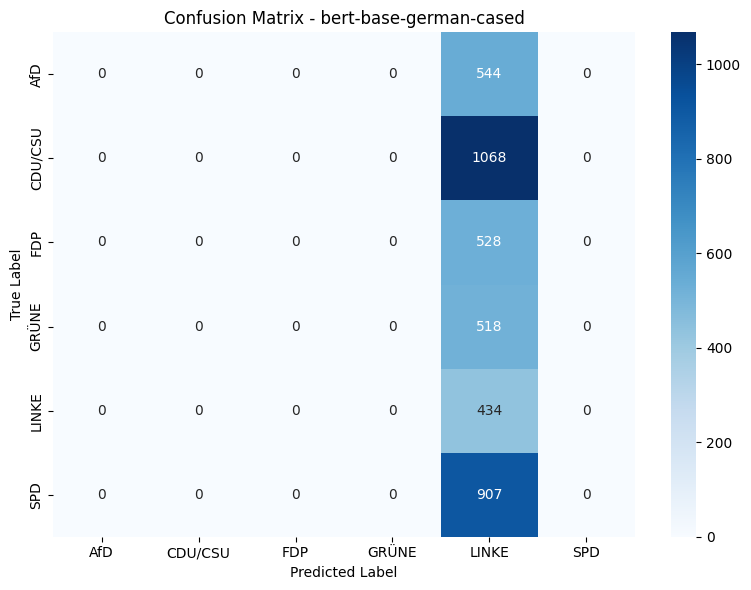

In [12]:
# Get zero-shot example performance
prediction_list, probability_list, true_label_list = evaluate_model(model, val_data)
print(probability_list)
BERT_Baseline_on_val_data = get_metrics(true_label_list, prediction_list)

In [ ]:
# fine-tunen



In [ ]:
# validaten



In [ ]:
# compare 2 versions (erinnern!)



In [ ]:
# outcomes test data conf matrix, accuracy



In [ ]:
# save model for futher tests on LLM generated speeches



__________________________________________________________________________________

Old to save
__________________________________________________________________________________

In [ ]:
# Load Model
model_name = "bert-base-german-cased"
num_labels = 6
max_length = 512
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels= num_labels) # classification head with one linear layer and num_label outputs is added on top of model here.

print(f"Model parameters: {model.num_parameters():,}")

# Put model in eval mode
model.eval()

# Define possible label names
label_names = ['CDU/CSU', 'SPD', 'GRÜNE', 'FDP', 'AfD', 'LINKE']

#  Tokenize input speeches
inputs = tokenizer(val_data_subset["speech_text"], return_tensors="pt", padding=True, truncation=False) # padding pads all speeches to the same length and truncation cuts all speeches to 512 tokens

# Run model to predict basline
with torch.no_grad(): # turns of gradient tracking, since we are not training
    outputs = model(**inputs) # passes tokenized inputs into model, returns output dict
    logits = outputs.logits # output dict contains logits
    probabilities = F.softmax(logits, dim=1) # logits to probabilities
    predictions = torch.argmax(probabilities, dim=1) # probabilities to predictions (i.e. highest probability)

# 7. Print prediction examples
for i, pred in enumerate(predictions):
    print(f"Speech {i+1}: predicted party = {label_names[pred]}")
print(logits)

for i, probs in enumerate(probabilities):
    print(f"Speech {i+1} prediction:")
    for label, prob in zip(label_names, probs):
        print(f"  {label:7s}: {prob.item():.2%}")

In [ ]:
# define prediction function
# Define possible label names
label_names = ['CDU/CSU', 'SPD', 'GRÜNE', 'FDP', 'AfD', 'LINKE']


def predicting_probs(model, speech):
    # Put model in eval mode
    model.eval()

    #  Tokenize input speeches
    tokens = tokenizer(speech, return_tensors="pt", truncation=False)["input_ids"][0]

    chunks = [tokens[i:i+max_length] for i in range(0, len(tokens), max_length)]

    all_probs = []
    i = 0
    for chunk in chunks:
        input_dict = {"input_ids": chunk.unsqueeze(0)}  # Add batch dimension
        # Add attention mask
        input_dict["attention_mask"] = (chunk != tokenizer.pad_token_id).unsqueeze(0)


        # Run model to predict baseline
        with torch.no_grad():
            outputs = model(**input_dict)
            logits = outputs.logits
            probabilities = F.softmax(logits, dim=1)
            all_probs.append(probabilities)
            i+=1
    # averaging probabilites over all probabilities in speech parts
    avg_probs = torch.mean(torch.cat(all_probs, dim=0), dim=0)
    #print(i , avg_probs)

    return avg_probs


def predicting_probs_to_preds(model, speech):
    # get probabilites
    probabilities = predicting_probs(model, speech)
    # convert to predictions
    predictions_nr = torch.argmax(probabilities).item()
    predictions = label_names[predictions_nr]
    return predictions, probabilities

